In [4]:
import os
from os import listdir
import glob

import multiprocessing as mp
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from plyfile import PlyData, PlyElement
import open3d as o3d

# **CREATE CSVs FOR EACH OBJECT**

In [26]:
ply0 = PlyData.read('../../data/paris_lille/paris_lille/Paris.ply')
ply1 = PlyData.read('../../data/paris_lille/paris_lille/Lille1.ply')
ply2 = PlyData.read('../../data/paris_lille/paris_lille/Lille2.ply')

def plyToData(ply_file):
    
    data = ply_file.elements[0].data

    data_pd = pd.DataFrame(data)
    data_np = np.zeros(data_pd.shape, dtype=np.float)
    property_names = data[0].dtype.names
    for i, name in enumerate(property_names):
        data_np[:,i] = data_pd[name]

    return data_np, data_pd


data_np0, data_pd0 = plyToData(ply0)
data_np1, data_pd1 = plyToData(ply1)
data_np2, data_pd2 = plyToData(ply2)

In [27]:
def createCSVObjectFile(df):
    
    for i in df.label.unique():
        
        df_ = df[df.label == i]
        
        if df_['class'].iloc[0] == 0 or df_['class'].iloc[0] == 100000000:
            continue
        else:
            file_name = "../../data/paris_lille/csv_objects/" + str(int(df_.iloc[0]['class'])) + "_" + str(int(df_.iloc[0].label)) + ".csv"
            df_.to_csv(file_name, index=False)

In [ ]:
num_cores = mp.cpu_count()
pool = mp.Pool(num_cores)

start = time.time()
csvs = pool.map(createCSVObjectFile, [data_pd0, data_pd1, data_pd2])
end = time.time()
print(end - start)

pool.close()

# **VOXELIZE EACH CSV**

In [3]:
def voxelize(filename):
    df = pd.read_csv(filename)
    df = df[['x', 'y', 'z']]
    points = df.to_numpy()
    
    points = points[np.logical_not(np.isnan(points).any(axis=1))]
    origin = (np.min(points[:, 0]), np.min(points[:, 1]), np.min(points[:, 2]))
    points[:, 0] -= origin[0]
    points[:, 1] -= origin[1]
    points[:, 2] -= origin[2]
    
    voxel_size=(24, 24, 24)
    padding_size=(32, 32, 32)
    resolution=0.1

    OCCUPIED = 1
    FREE = 0
    
    x_logical = np.logical_and((points[:, 0] < voxel_size[0] * resolution), (points[:, 0] >= 0))
    y_logical = np.logical_and((points[:, 1] < voxel_size[1] * resolution), (points[:, 1] >= 0))
    z_logical = np.logical_and((points[:, 2] < voxel_size[2] * resolution), (points[:, 2] >= 0))
    xyz_logical = np.logical_and(x_logical, np.logical_and(y_logical, z_logical))
    inside_box_points = points[xyz_logical] 

    voxels = np.zeros(padding_size)
    center_points = inside_box_points + (padding_size[0] - voxel_size[0]) * resolution / 2
    x_idx = (center_points[:, 0] / resolution).astype(int)
    y_idx = (center_points[:, 1] / resolution).astype(int)
    z_idx = (center_points[:, 2] / resolution).astype(int)
    voxels[x_idx, y_idx, z_idx] = OCCUPIED
    
    npy_filename = '../../data/paris_lille/npy_objects_method1/' + filename.split('.')[0].split('/')[-1] + '.npy'
    np.save(npy_filename, voxels)

In [8]:
csv_dir = '/home/jupyter-seanandrewchen/shared/cusp-capstone/data/paris_lille/csv_objects/'
input_path = os.path.join(csv_dir, '*.csv')

num_cores = mp.cpu_count()
pool = mp.Pool(num_cores)

start = time.time()
voxelizations = pool.map(voxelize, glob.glob(input_path))
end = time.time()
print(end - start)

pool.close()

28.473743438720703


In [ ]:
#csv_dir = '/home/jupyter-seanandrewchen/shared/cusp-capstone/data/paris_lille/csv_objects/'
#input_path = os.path.join(csv_dir, '*.csv')
#for csv in glob.iglob(input_path):
#    voxelize(csv)

# **INSPECT FILES**

In [5]:
def plot3DVoxel(voxels):
    fig = plt.figure('Point Cloud 3D Voxelization')
    plt3d = fig.gca(projection='3d')

    occupied = (voxels == 1)
    free = (voxels == 0)

    # # set the colors of each object
    colors = np.zeros(voxels.shape + (4,))
    colors[free] = [0.1, 0.1, 0.1, 0.1]
    colors[occupied] = [0.8, 0.8, 0.8, 1.0]

    # setting camera angle
    plt3d.set_xlabel('X', fontsize=9)
    plt3d.set_ylabel('Y', fontsize=9)
    plt3d.set_zlabel('Z', fontsize=9)
    plt3d.set_xlim3d(0, voxels.shape[0])
    plt3d.set_ylim3d(0, voxels.shape[1])
    plt3d.set_zlim3d(0, voxels.shape[2])

    # and plot everything
    # plt3d.voxels(occupied | free, facecolors=colors, edgecolor='k', linewidth=0.8)
    plt3d.voxels(occupied, facecolors=colors, edgecolor='k', linewidth=0.8)

    dx, dy, dz = voxels.shape
    x = y= z = 0
    xx = [x, x, x+dx, x+dx, x]
    yy = [y, y+dy, y+dy, y, y]
    kwargs = {'alpha': 1, 'color': 'red'}
    plt3d.plot3D(xx, yy, [z]*5, **kwargs)
    plt3d.plot3D(xx, yy, [z+dz]*5, **kwargs)
    plt3d.plot3D([x, x], [y, y], [z, z+dz], **kwargs)
    plt3d.plot3D([x, x], [y+dy, y+dy], [z, z+dz], **kwargs)
    plt3d.plot3D([x+dx, x+dx], [y+dy, y+dy], [z, z+dz], **kwargs)
    plt3d.plot3D([x+dx, x+dx], [y, y], [z, z+dz], **kwargs)

    plt.show()

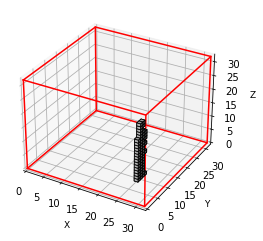

In [6]:
voxels = np.load('../../data/paris_lille/npy_objects_method1/302020400_159.npy').astype(np.float32)
plot3DVoxel(voxels)

# **LOAD ALL NPY FILES**

In [2]:
path = os.path.join('../../data/paris_lille/npy_objects/', '*.npy')

voxels_list = []
label_list = []

for npy_file in glob.iglob(path):
    
    file_name = npy_file.split('/')[-1].split('_')[0]
    label_list.append(file_name)
    
    voxels = np.load(npy_file).astype(np.float32)
    voxels_list.append(voxels)